In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from natsort import natsorted
from PIL import Image
from PIL import ImageFile
from skimage import io, color, transform
import utils

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
AB_scale = 128
img_transform = transforms.Compose([transforms.ToTensor()]) 
dataset = utils.LabDataSet('data/anime',img_transform, train_size= 1000, test_size=128*2, height=256, width=256)

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=dataset.train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset.test_set, batch_size=batch_size, shuffle=False)

In [6]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.inputConv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
    self.bn_2D = nn.BatchNorm2d(64)
    self.maxPool2D=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    

  def forward(self, image):
    # layer_1 = self.maxPool2D(F.relu(self.bn_2D(self.inputConv(image))))

    resnet = torchvision.models.resnet18(num_classes=2)
    resnet.to(device) 
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
    midlevel_features = midlevel_resnet(image)
    return midlevel_features

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    # self.fc    = nn.Linear(in_features=10,out_features=2*64*7*7)
    # self.convTran1 = nn.ConvTranspose2d(in_channels=2*64,out_channels=64, kernel_size=4, stride=2, padding=1)
    # self.convTran2 = nn.ConvTranspose2d(in_channels=64,out_channels=1, kernel_size=4, stride=2, padding=1)
    self.conv1 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.conv2 =  nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 =  nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.conv4 =  nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
    self.conv5 =  nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)

    nn.init.xavier_normal_(self.conv1.weight)
    nn.init.xavier_normal_(self.conv2.weight)
    nn.init.xavier_normal_(self.conv3.weight)
    nn.init.xavier_normal_(self.conv4.weight)
    nn.init.xavier_normal_(self.conv5.weight)


    self.upsample = nn.Sequential(     

      self.conv1,
      nn.BatchNorm2d(128),
      nn.ReLU(),

      nn.Upsample(scale_factor=2),

      self.conv2,
      nn.BatchNorm2d(64),
      nn.ReLU(),


      self.conv3,
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Upsample(scale_factor=2),


      self.conv4,
      nn.Sigmoid(),
      self.conv5,
      nn.Upsample(scale_factor=2)
    )
    
  def forward(self, latent):
    return self.upsample(latent)

In [7]:
class Autoencoder(nn.Module):
   def __init__(self):
      super(Autoencoder, self).__init__()
      # self.encoder = Encoder()
      # self.decoder = Decoder()
      self.relu = nn.ReLU()

      self.final = nn.Tanh()
      
      self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
      
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=2, padding=1, bias=True)
      self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=2, padding=1, bias=True)
      self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=2, padding=1, bias=True)
      self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv8 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv9 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv10 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv11 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
      self.conv12 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=(3,3), stride=1, padding=1, bias=True)


      self.color = nn.Sequential(
          self.conv1,
          self.relu,
          self.conv2,
          self.relu,
          self.conv3,
          self.relu,
          self.conv4,
          self.relu,
          self.conv5,
          self.relu,
          self.conv6,
          self.relu,
          self.conv7,
          self.relu,
          self.conv8,
          self.relu,
          self.conv9,
          self.relu,
          self.upsampling,
          self.conv10,
          self.relu,
          self.upsampling,
          self.conv11,
          self.relu,
          self.conv12,
          self.final,
          self.upsampling
      )

   def forward(self, x):
     return self.color(x)

     #    latent = self.encoder(x)
     #    x_recon = self.decoder(latent)
     #    return  x_recon

In [8]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = [] 
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
    
      for image_batch, image_batch_r, name_image in train_loader:
          image_batch_r = image_batch_r.to(device)
          
          image_batch = torch.unsqueeze(image_batch, dim=1)
          image_batch = image_batch.to(device)

          image_batch_recon = model(image_batch)
          loss = loss_fn(image_batch_recon, image_batch_r)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
      if epoch%5==0 and epoch!=0:
        utils.plot_batch(device, test_loader, model, step =16)
        model.train()
    return train_loss_avg

Epoch [1 / 100] average error: 0.017774
Epoch [2 / 100] average error: 0.014320
Epoch [3 / 100] average error: 0.014064
Epoch [4 / 100] average error: 0.013957
Epoch [5 / 100] average error: 0.013909
Epoch [6 / 100] average error: 0.013769


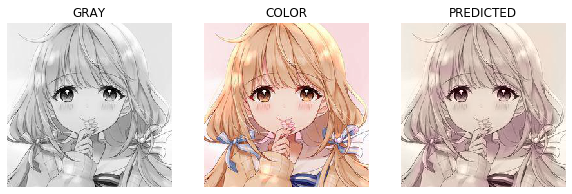

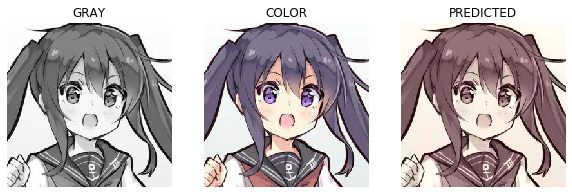

Epoch [7 / 100] average error: 0.013827
Epoch [8 / 100] average error: 0.013821
Epoch [9 / 100] average error: 0.013646
Epoch [10 / 100] average error: 0.013430
Epoch [11 / 100] average error: 0.013405


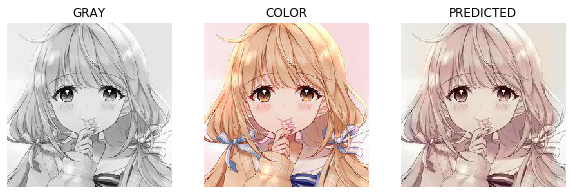

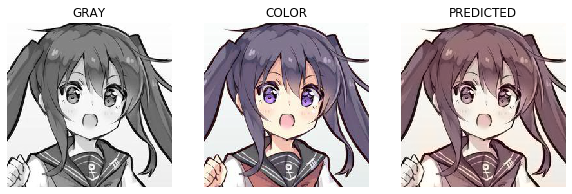

Epoch [12 / 100] average error: 0.013566


In [9]:
learning_rate = 1e-3
autoencoder = Autoencoder()
autoencoder.to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate)

autoencoder.train()
loss_result = train(autoencoder,train_loader,100,loss)

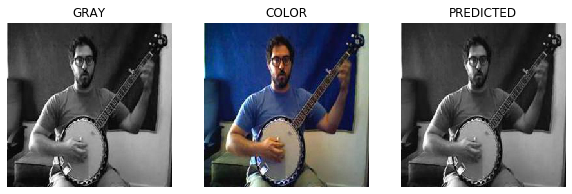

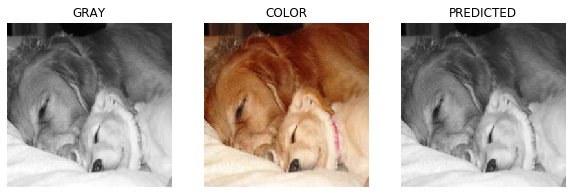

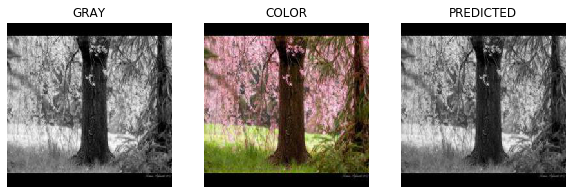

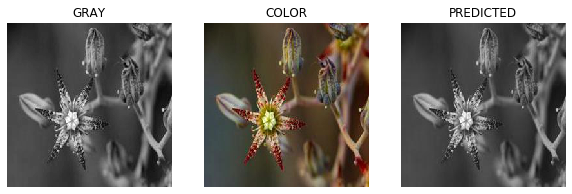

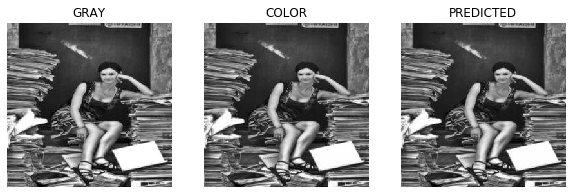

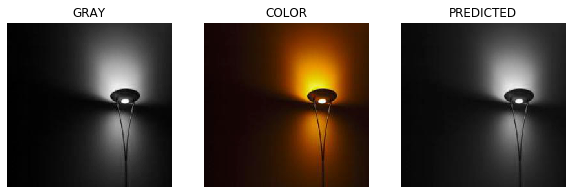

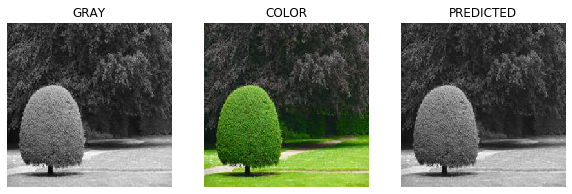

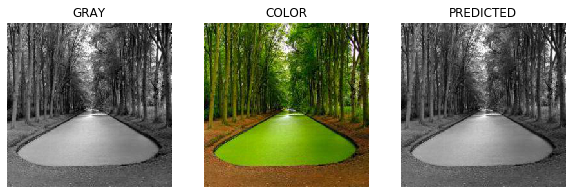

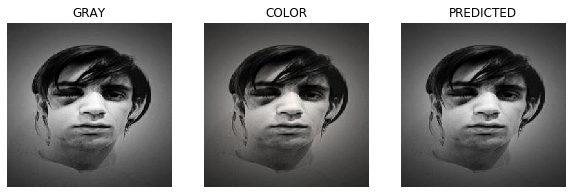

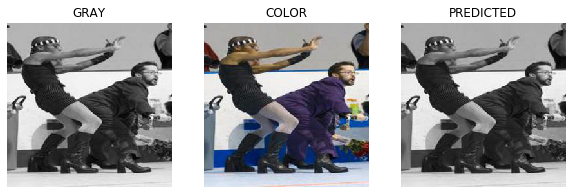

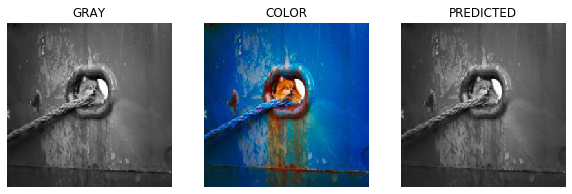

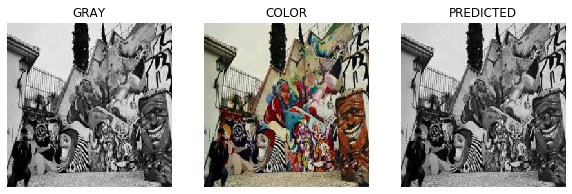

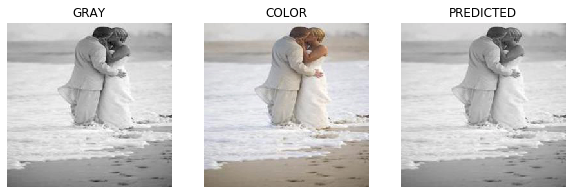

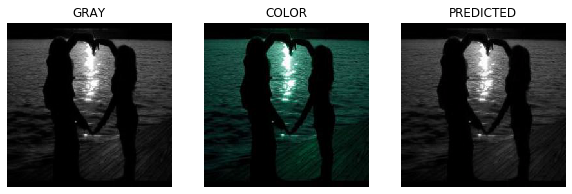

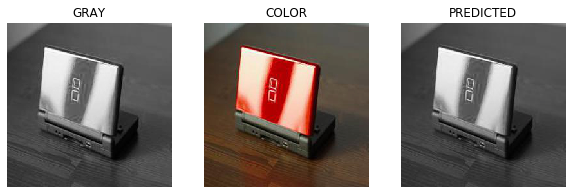

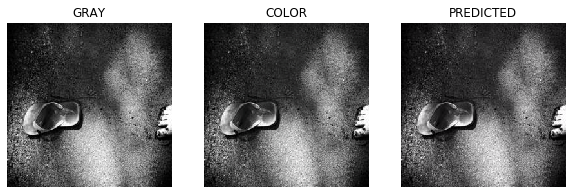

KeyboardInterrupt: 

In [10]:
utils.plot_batch(device, test_loader, autoencoder, step =1)

In [ ]:
# model_scripted = torch.jit.script(autoencoder) # Export to TorchScript
# model_scripted.save('mse_landscapes.pt') #

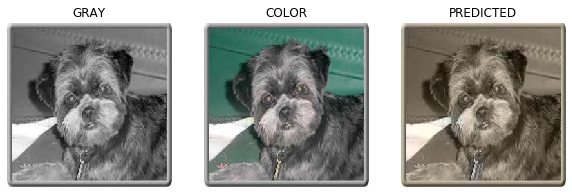

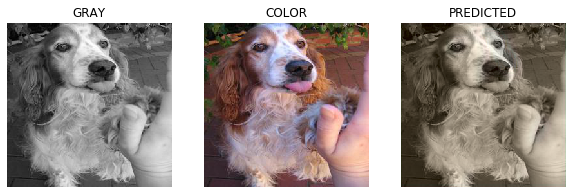

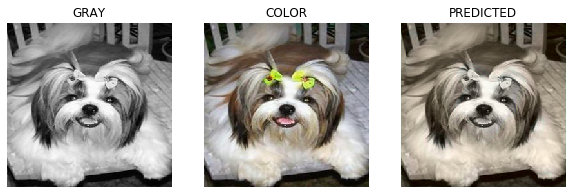

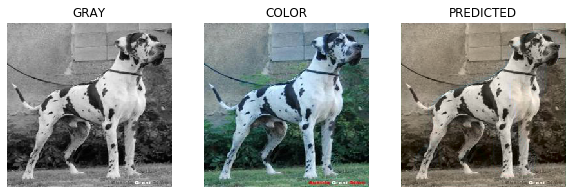

In [ ]:
def plot_validation(model = None ,pos=0, height=256, width=256):
    with torch.no_grad():
        for image_batch, image_batch_r,name in test_loader:
            figure,axis = plt.subplots(1,3,figsize=(10,10))
            axis[0].set_title("GRAY")
            axis[1].set_title("COLOR")
            axis[2].set_title("PREDICTED")

            axis[0].axis("off")
            axis[1].axis("off")
            axis[2].axis("off")
            L = (np.asarray(image_batch[pos])) * 100
            A = np.asarray(image_batch_r[pos][0]) *AB_scale
            B = np.asarray(image_batch_r[pos][1]) *AB_scale

            image_batch2 = torch.unsqueeze(image_batch, dim=1)
            datos = []
            for i in range(L.shape[0]):
                for j in range(L.shape[1]):
                    datos.append([L[i,j], A[i,j], B[i,j]])

            datos = np.reshape(datos, (height,width,3))
            rgb = color.lab2rgb(datos)
            axis[0].imshow(L, cmap='gray')
            axis[1].imshow(rgb)
            resultado = model(image_batch2.to(device))

            A = (resultado[pos][0].detach().cpu().numpy()) *AB_scale
            B = (resultado[pos][1].detach().cpu().numpy()) *AB_scale
            datos = []
            for i in range(L.shape[0]):
                for j in range(L.shape[1]):
                    datos.append([L[i,j], A[i,j], B[i,j]])

            datos = np.reshape(datos, (height,width,3))
            rgb = color.lab2rgb(datos)

            axis[2].imshow(rgb)
            plt.show()


plot_validation(autoencoder)

In [ ]:
# resnet = torchvision.models.resnet18(num_classes=365) 
# # Change first conv layer to accept single-channel (grayscale) input
# resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
# midlevel_resnet = nn.Sequential(*list(resnet.children())[:6])
# print(*list(resnet.children())[:6],"")